# Predicting Conformational Ensemebles with Subsampled AF2

This notebook replicates the methods used to generate the deep MSA for predicting conformational ensembles like the ones described in the "Predicting Relative Populations of Protein Conformations without a Physics Engine Using AlphaFold2" 2023 pre-print (Monteiro da Silva et. al, 10.1101/2023.07.25.550545v1).

Importantly, this notebook does not include a cell for actually running AF2, as collab sessions usually do not have sufficient resources to run AF2 with deep MSAs. We've included the methods for running AF2 as we did at the end of the notebook, complete with code snippets.

This notebook also does not include analysis of the predicted results for the relative state populations or conformational diversity or mechanistic insights, as that is system and goal-dependant. We suggest the usage of PyMol, PyTraj, MDTraj, Chimera, or other structure/trajectory analysis methods for that purpose.

Code snippets were mostly taken with few adaptations from the AlphaFold2_advanced collab notebook from the ColabFold implementation (https://github.com/sokrypton/ColabFold), and all the credits belong to the original authors (Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S and Steinegger M., Jumper et al)

In [1]:
#@title Install software
#@markdown Please execute this cell by pressing the _Play_ button
#@markdown on the left.

# setup device
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys
import tensorflow as tf
import jax

try:
  # check if TPU is available
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
  print('Running on TPU')
  DEVICE = "tpu"
except:
  if jax.local_devices()[0].platform == 'cpu':
    print("WARNING: no GPU detected, will be using CPU")
    DEVICE = "cpu"
  else:
    print('Running on GPU')
    DEVICE = "gpu"
    # disable GPU on tensorflow
    tf.config.set_visible_devices([], 'GPU')

from IPython.utils import io
import subprocess
import tqdm.notebook

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

install_jackhmmer = True
GIT_REPO = 'https://github.com/deepmind/alphafold'
SOURCE_URL = 'https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar'
PARAMS_DIR = './alphafold/data/params'
PARAMS_PATH = os.path.join(PARAMS_DIR, os.path.basename(SOURCE_URL))
TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'
TMP_DIR = "tmp"
os.makedirs(TMP_DIR, exist_ok=True)

# if not already installed
total = 55
with tqdm.notebook.tqdm(total=total, bar_format=TQDM_BAR_FORMAT) as pbar:
  if not os.path.isdir("alphafold"):
    # download alphafold code
    os.system(f"git clone {GIT_REPO} alphafold; cd alphafold; git checkout 1d43aaff941c84dc56311076b58795797e49107b")
    os.system(f"git clone https://github.com/sokrypton/ColabFold.git")

    # apply patches
    os.system(f"patch -u alphafold/alphafold/model/model.py -i ColabFold/beta/model.patch")
    os.system(f"patch -u alphafold/alphafold/model/mapping.py -i ColabFold/beta/mapping.patch")
    os.system(f"patch -u alphafold/alphafold/model/modules.py -i ColabFold/beta/modules.patch")
    os.system(f"patch -u alphafold/alphafold/model/folding.py -i ColabFold/beta/folding.patch")
    os.system(f"patch -u alphafold/alphafold/model/config.py -i ColabFold/beta/config.patch")
    # apply multi-chain patch from Lim Heo @huhlim
    os.system(f"patch -u alphafold/alphafold/common/protein.py -i ColabFold/beta/protein.patch")
    pbar.update(4)

    os.system(f"pip install biopython dm-haiku==0.0.9 ml-collections py3Dmol")
    pbar.update(6)

    # download model params (speedup from kaczmarj)
    os.system(f"mkdir --parents {PARAMS_DIR}")
    os.system(f"curl -fsSL {SOURCE_URL} | tar x -C {PARAMS_DIR}")
    pbar.update(14+27)

    # install hhsuite
    os.system(f"curl -fsSL https://github.com/soedinglab/hh-suite/releases/download/v3.3.0/hhsuite-3.3.0-SSE2-Linux.tar.gz | tar xz -C {TMP_DIR}/")

    # install jackhmmer
    if install_jackhmmer:
      os.system(f"sudo apt install --quiet --yes hmmer")
      pbar.update(3)

      # create a ramdisk to store a database chunk to make Jackhmmer run fast.
      os.system(f"sudo mkdir -m 777 --parents /tmp/ramdisk")
      os.system(f"sudo mount -t tmpfs -o size=9G ramdisk /tmp/ramdisk")
      pbar.update(1)

    else:
      pbar.update(4)

  else:
    pbar.update(55)

########################################################################################
# --- Python imports ---
if 'alphafold' not in sys.path:
  sys.path.append('alphafold')
if 'ColabFold/beta' not in sys.path:
  sys.path.append('ColabFold/beta')

if f"{TMP_DIR}/bin" not in os.environ['PATH']:
  os.environ['PATH'] += f":{TMP_DIR}/bin:{TMP_DIR}/scripts"

import colabfold as cf
import colabfold_alphafold as cf_af

import json
import matplotlib.pyplot as plt
import numpy as np

try:
  from google.colab import files
  IN_COLAB = True
except:
  IN_COLAB = False

  0%|          | 0/55 [elapsed: 00:00 remaining: ?]

/usr/local/lib/python3.10/dist-packages/Bio/Data/SCOPData.py:18: BiopythonDeprecationWarning: The 'Bio.Data.SCOPData' module will be deprecated in a future release of Biopython in favor of 'Bio.Data.PDBData.
  warnings.warn(


In [2]:
#@title Enter the amino acid sequence to predict ensembles for⬇️
import re

# define sequence
sequence = 'PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK' #@param {type:"string"}
jobname = "test" #@param {type:"string"}
homooligomer =  "1"

I = cf_af.prep_inputs(sequence, jobname, homooligomer, clean=IN_COLAB)

homooligomer: 1
total_length: 59
output_dir: prediction_test_a5e17


running mmseqs2


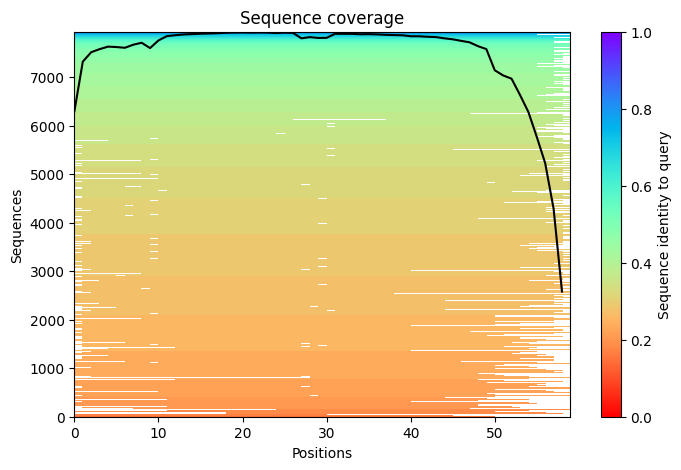

In [4]:
#@title Search against genetic databases
#@markdown Once this cell has been executed, you will see
#@markdown statistics about the multiple sequence alignment
#@markdown (MSA) that will be used by AlphaFold. In particular,
#@markdown you’ll see how well each residue is covered by similar
#@markdown sequences in the MSA.
#@markdown (Note that the search against databases and the actual prediction can take some time, from minutes to hours, depending on the length of the protein and what type of GPU you are allocated by Colab.)

#@markdown ---
msa_method = "jackhmmer" # @param ["jackhmmer", "mmseqs2"]
#@markdown - `mmseqs2` - FAST method from [ColabFold](https://github.com/sokrypton/ColabFold) NOT RECOMMENDED FOR PREDICTING ENSEMBLES as output MSAs are usually shallow compared to JackHMMR
#@markdown - `jackhmmer` - default method from Deepmind (SLOW, usually finds more sequences)
#@markdown you can skip this step by uploading
#@markdown the previously generated  `prediction_?????/msa.pickle`


add_custom_msa = False
msa_format = "fas"
pair_mode = "unpaired"



pair_cov = 50
pair_qid = 20
# --- Search against genetic databases ---

I = cf_af.prep_msa(I, msa_method, add_custom_msa, msa_format,
                   pair_mode, pair_cov, pair_qid, TMP_DIR=TMP_DIR)
mod_I = I

if len(I["msas"][0]) > 1:
  plt = cf.plot_msas(I["msas"], I["ori_sequence"])
  plt.savefig(os.path.join(I["output_dir"],"msa_coverage.png"), bbox_inches = 'tight', dpi=200)
  plt.show()

In [5]:
#@title Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [6]:
#@title Reformat and Save MSA to Drive
import ast

original_array = I['msas']

def reformat_sequences(input_array):
    formatted_sequences = []
    for idx, sequence in enumerate(input_array[0]):
        formatted_sequence = f">sequence_{idx + 1}\n{sequence}\n"
        formatted_sequences.append(formatted_sequence)
    return formatted_sequences

formatted_sequences = reformat_sequences(original_array)

def save_formatted_sequences_to_file(formatted_sequences, output_file):
    with open(f'/content/gdrive/My Drive/{output_file}', 'w') as f:
        for sequence in formatted_sequences:
            f.write(sequence)

output_msa_name = "656" # @param {type:"string"}
output_file = output_msa_name + '.a3m'
# @markdown - `output_msa_name` name of the `.a3m` MSA to be saved to Drive.
save_formatted_sequences_to_file(formatted_sequences, output_file)

In [ ]:
#@title Instructions for running AF2
# @markdown To make predictions, we've used localcolabfold (https://github.com/YoshitakaMo/localcolabfold) installed in an HPC. To use the large MSAs generated from JackHMMR a lot of RAM is needed (128GB+ for Abl1 with 600k+ sequences deep MSAs).

# @markdown When making predictions for a new system, we usually seek to optimize the `max-seq:max-extra-seq` parameters to maximize the diversity of results (see Figure S1 and S2 on the preprint for more information of what these parameters do and how they affect predictions for an example system).
# @markdown
# @markdown Parameter `max-seq` seems to be the most important of the pair for maximizing diversity.

# @markdown We usually do that by systematically running AF2 with 32+ seeds with different`max-seq:max-extra-seq` parameters and analyzing the distribution of relevant observables among the results using Pymol or PyTraj or VMD or mdtraj or whatever analysis method you prefer.

# @markdown Below is the command we used to generate one of the Wild-Type Abl1 ensembles described in the pre-print.

# @markdown `colabfold_batch --num-seeds 32 --max-msa 256:512 --use-dropout --random-seed 1 abl1_wt.a3m  /output_ablwt_dropout_256512_32_1`

# @markdown This should generate 160 .pdb files (32 seeds * 5 models).

# @markdown `--use-dropout` is so AF2 will learn from the uncertainty of the results when predicting with multiple seeds.

# @markdown Other relevant parameters are the number of recycles (`--num-recycles`, left as default in the example above) and the starting seed in case you're running replicates (`--random-seed` sets the first seed at that number, then it increments it by one for each seed in `--num-seeds`). Decreasing the number of recycles seems to increase the conformational diversity of the ensemble, which makes sense since the MSA is resampled at every recycle.